In [1]:
cd ..

/Users/timothychan/marathon/marathon-repo


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import marathon.marathonlib as m
import numpy as np

%matplotlib inline

In [3]:
df = pd.read_csv('marathon/data/boston2015_clean.csv')
df.columns

Index([u'marathon_id', u'year', u'bib', u'url', u'name', u'firstname',
       u'lastname', u'age', u'gender', u'city', u'state', u'country',
       u'citizenship', u'subgroup', u'gunstart', u'starttime', u'time5k',
       u'time10k', u'time15k', u'time20k', u'timehalf', u'time25k', u'time30k',
       u'time35k', u'time40k', u'pace', u'projtime', u'offltime', u'nettime',
       u'overall_rank', u'gender_rank', u'division_rank', u'other1', u'other2',
       u'other3', u'other4'],
      dtype='object')

## Features
| feature | comment |
|---------|---------|
| bib     | integer, need to strip 'F' from female pros
| age     | integer
| gender  | boolean
| origin  | categorical, merge of state/country.  Count values and merge misc. categories
| elite   | boolean
| qualifier | boolean
| injured | boolean
| over45 | boolean

In [4]:
model_df = pd.DataFrame()

In [5]:
model_df['offltime'] = df['offltime']

In [6]:
bibs = []
for s in df['bib']:
    try:
        bibs.append(int(s))
    except ValueError:
        bibs.append(int(s[1:]))
print min(bibs), max(bibs)
model_df['bib'] = bibs

1 31618


In [7]:
model_df['age'] = df['age']
model_df['gender'] = df['gender']

In [8]:
# create home category
model_df['home'] = [state if country=='USA' else country for country,state in df[['country','state']].values]
count_df = model_df['home'].value_counts()
misc_list = count_df[count_df < 9].index
print misc_list
for ix in range(len(model_df)):
    if model_df['home'][ix] in misc_list:
        model_df['home'].iloc[ix] = 'MISC'
print sum(model_df['home']=='MISC')

Index([u'PAN', u'ETH', u'POR', u'IND', u'AE', u'ECU', u'CZE', u'CAY', u'MAS',
       u'DOM', u'GRE', u'TUR', u'TRI', u'AA', u'ESA', u'SLO', u'INA', u'ROU',
       u'CRO', u'MAR', u'LTU', u'GU', u'AP', u'UAE', u'EST', u'BAH', u'PHI',
       u'VGB', u'VI', u'LIE', u'AHO', u'VIE', u'UGA', u'BLR', u'URU', u'OMA',
       u'AND', u'QAT', u'CYP', u'LUX', u'JAM', u'UKR', u'LAT'],
      dtype='object')
116


/Users/timothychan/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
model_df['elite'] = map(lambda x: len(x)>1, df['url'])

In [10]:
# qualifier
qual_end = 25450
nqual_start = 25700
print 'Total records:', len(model_df)
print 'Number of qualifiers:', sum(model_df['bib'] < qual_end)    # 20974
print 'Number of non-qualifiers:', sum(model_df['bib'] >= nqual_start) # 5214
print 'Number of records to discard:',sum((model_df['bib'] >= qual_end) & (model_df['bib']<nqual_start))

print 'Number of records to keep:',sum((model_df['bib'] < qual_end) | (model_df['bib'] >= nqual_start))
model_df = model_df[(model_df['bib'] < qual_end) | (model_df['bib'] >= nqual_start)]
print 
print 'Number of records kept:', len(model_df)

model_df['qualifier'] = model_df['bib'] < qual_end
print model_df['qualifier'].value_counts()

Total records: 26403
Number of qualifiers: 20974
Number of non-qualifiers: 5215
Number of records to discard: 214
Number of records to keep: 26189

Number of records kept: 26189
True     20974
False     5215
Name: qualifier, dtype: int64


In [11]:
# injured
def is_injured(runner):
    return False



In [12]:
# over45
model_df['over45'] = model_df['age'] > 45

In [13]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26189 entries, 0 to 26402
Data columns (total 8 columns):
offltime     26189 non-null object
bib          26189 non-null int64
age          26189 non-null int64
gender       26189 non-null bool
home         26189 non-null object
elite        26189 non-null bool
qualifier    26189 non-null bool
over45       26189 non-null bool
dtypes: bool(4), int64(2), object(2)
memory usage: 1.1+ MB


# Modelling data with BIB number left out

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Lasso

In [15]:
df_dummies = pd.get_dummies(model_df, columns=['home'])
df_dummies = df_dummies.drop(['bib', 'home_MISC'],axis=1)
y = df_dummies.pop('offltime')
y = pd.Series(map(m.time_to_minutes, y))
X = df_dummies.values

coeff_names = df_dummies.columns

print X.shape
print y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y)


(26189, 97)
(26189,)


In [16]:
model = LinearRegression()

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)

training R2: 0.592490393941
testing R2: 0.587761868829


In [17]:
model = Lasso(alpha=0.25)

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)
print 
print 'Lasso Coefficients'
print '------------------'
print '{0:10}{1}'.format('intercept', model.intercept_)
for name, coef in zip(coeff_names, model.coef_):
    if abs(coef) > 0.001:
        print '{0:10}{1}'.format(name, coef)

training R2: 0.5802218667
testing R2: 0.578756350172

Lasso Coefficients
------------------
intercept 232.946066919
age       1.37319029939
gender    -26.1190138088
qualifier -63.4311420619
home_MA   1.40199258098


### Try Lasso with bib number in data

In [18]:
df_dummies = pd.get_dummies(model_df, columns=['home'])
df_dummies = df_dummies.drop(['home_MISC'],axis=1)
y = df_dummies.pop('offltime')
y = pd.Series(map(m.time_to_minutes, y))
X = df_dummies.values

coeff_names = df_dummies.columns

print X.shape
print y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y)
model = Lasso(alpha=0.25)

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)
print 
print 'Lasso Coefficients'
print '------------------'
print '{0:10}{1}'.format('intercept', model.intercept_)
for name, coef in zip(coeff_names, model.coef_):
    if abs(coef) > 0.001:
        print '{0:10}{1}'.format(name, coef)

(26189, 98)
(26189,)
training R2: 0.640241767549
testing R2: 0.645716022326

Lasso Coefficients
------------------
intercept 181.175371245
bib       0.00268921838165
age       0.43074724789
gender    -3.95154868032
qualifier -17.4441587181
home_MA   0.638755653683


### Try regression on over45 == True

In [19]:
df_dummies = pd.get_dummies(model_df[model_df['over45']], columns=['home'])
df_dummies = df_dummies.drop(['bib', 'home_MISC'],axis=1)
y = df_dummies.pop('offltime')
y = pd.Series(map(m.time_to_minutes, y))
X = df_dummies.values

coeff_names = df_dummies.columns

print X.shape
print y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LinearRegression()

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)

(10330, 96)
(10330,)
training R2: 0.530292172346
testing R2: 0.544402316072


### Try regression on over45 == False

In [20]:
df_dummies = pd.get_dummies(model_df[model_df['over45']==False], columns=['home'])
df_dummies = df_dummies.drop(['bib', 'home_MISC'],axis=1)
y = df_dummies.pop('offltime')
y = pd.Series(map(m.time_to_minutes, y))
X = df_dummies.values

coeff_names = df_dummies.columns

print X.shape
print y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LinearRegression()

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)

(15859, 97)
(15859,)
training R2: 0.625625389915
testing R2: 0.607021054887


### Try regression on qualifiers

In [21]:
df_dummies = pd.get_dummies(model_df[model_df['qualifier']], columns=['home'])
df_dummies = df_dummies.drop(['bib', 'home_MISC'],axis=1)
y = df_dummies.pop('offltime')
y = pd.Series(map(m.time_to_minutes, y))
X = df_dummies.values

coeff_names = df_dummies.columns

print X.shape
print y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = Lasso(alpha=0.25)

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)
print 
print 'Lasso Coefficients'
print '------------------'
print '{0:10}{1}'.format('intercept', model.intercept_)
for name, coef in zip(coeff_names, model.coef_):
    if abs(coef) > 0.001:
        print '{0:10}{1}'.format(name, coef)

(20974, 97)
(20974,)
training R2: 0.430088317835
testing R2: 0.454820996378

Lasso Coefficients
------------------
intercept 164.721362255
age       1.49242067824
gender    -26.8900573497
home_CAN  -0.0658183684284


### Try regression on nonqualifiers

In [22]:
df_dummies = pd.get_dummies(model_df[model_df['qualifier']==False], columns=['home'])
df_dummies = df_dummies.drop(['bib', 'home_MISC'],axis=1)
y = df_dummies.pop('offltime')
y = pd.Series(map(m.time_to_minutes, y))
X = df_dummies.values

coeff_names = df_dummies.columns

print X.shape
print y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = Lasso(alpha=0.25)

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)
print 
print 'Lasso Coefficients'
print '------------------'
print '{0:10}{1}'.format('intercept', model.intercept_)
for name, coef in zip(coeff_names, model.coef_):
    if abs(coef) > 0.001:
        print '{0:10}{1}'.format(name, coef)

(5215, 88)
(5215,)
training R2: 0.1078842048
testing R2: 0.103418653157

Lasso Coefficients
------------------
intercept 252.72004304
age       0.818054223135
gender    -21.2469118234
over45    0.391486193502
home_ITA  -4.32594587013
home_MA   1.45345564379


non-qualifiers are a much more heterogeneous population.  A lot of variance in this group.

## Evaluate other models

In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
df_dummies = pd.get_dummies(model_df, columns=['home'])
df_dummies = df_dummies.drop(['bib', 'home_MISC'],axis=1)
y = df_dummies.pop('offltime')
y = pd.Series(map(m.time_to_minutes, y))
X = df_dummies.values

coeff_names = df_dummies.columns

print X.shape
print y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = RandomForestRegressor(n_estimators=10, n_jobs=-1)

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)

(26189, 97)
(26189,)
training R2: 0.705187642659
testing R2: 0.548212502968


In [25]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)

training R2: 0.712509236262
testing R2: 0.557174417792


In [26]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100, max_depth=3)

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)

training R2: 0.560502332531
testing R2: 0.568921197477


In [27]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100, max_depth=5)

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)

training R2: 0.606133619846
testing R2: 0.608727955088


In [28]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100, max_depth=7)

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)

training R2: 0.621221256262
testing R2: 0.609337678691


In [29]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=25, max_depth=7)

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)

training R2: 0.620456626775
testing R2: 0.608793557379


In [30]:
from sklearn.ensemble import AdaBoostRegressor

In [31]:
model = AdaBoostRegressor(n_estimators=5000, learning_rate=0.1)

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)

training R2: 0.41677930772
testing R2: 0.421177573228


In [32]:
from sklearn.svm import SVR

In [33]:
model = SVR()

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)

training R2: 0.401940462085
testing R2: 0.407016262841


## Examine best model

In [34]:
df_dummies = pd.get_dummies(model_df, columns=['home'])
df_dummies = df_dummies.drop(['bib', 'home_MISC'],axis=1)
y = df_dummies.pop('offltime')
y = pd.Series(map(m.time_to_minutes, y))
X = df_dummies.values

coeff_names = df_dummies.columns

print X.shape
print y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = Lasso(alpha=0.25)

model.fit(X_train, y_train)
print 'training R2:',model.score(X_train, y_train)
y_predict = model.predict(X_test)
print 'testing R2:',model.score(X_test, y_test)
print 
print 'Lasso Coefficients'
print '------------------'
print '{0:10}{1}'.format('intercept', model.intercept_)
for name, coef in zip(coeff_names, model.coef_):
    if abs(coef) > 0.001:
        print '{0:10}{1}'.format(name, coef)

(26189, 97)
(26189,)
training R2: 0.582312608522
testing R2: 0.572360375765

Lasso Coefficients
------------------
intercept 233.431117031
age       1.36151426668
gender    -26.1831120627
qualifier -63.4830795877
home_MA   1.3136829107


In [39]:
# Select features

def plot_model_on_data(field_gender, field_qualifier, alpha=0.01):
    """
    Parameters
    ----------
    field_gender : boolean
    field_qualifier : boolean
    """
    df = model_df[(model_df['gender']==field_gender) & (model_df['qualifier']==field_qualifier)]

    # plot
    y = map(m.time_to_minutes, df['offltime'])
    plt.scatter(df['age'], y, alpha=alpha)

    def equation(x):
        INTERCEPT = 233.43
        B_AGE = 1.362
        B_GENDER = -26.18
        B_QUALIFIER = -63.48
        return INTERCEPT + x*B_AGE + B_GENDER*field_gender + B_QUALIFIER*field_qualifier
    x = range(20,80)
    line = [equation(i) for i in x]
    plt.plot(x, line)
    plt.legend(['data','model'])

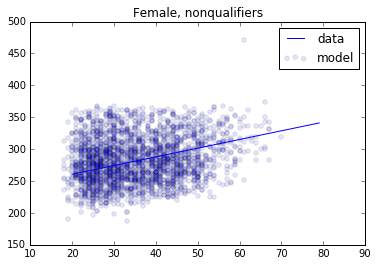

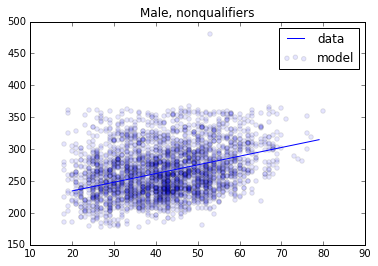

In [40]:
plot_model_on_data(False, False, 0.1)
plt.title('Female, nonqualifiers')
plt.show()
plot_model_on_data(True, False, 0.1)
plt.title('Male, nonqualifiers')
plt.show()

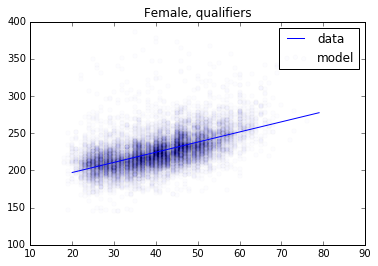

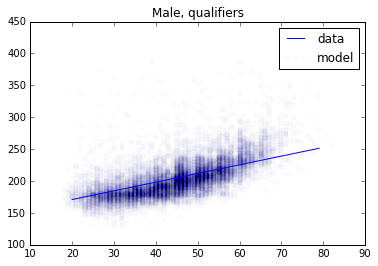

In [41]:
plot_model_on_data(False, True)
plt.title('Female, qualifiers')
plt.show()
plot_model_on_data(True, True)
plt.title('Male, qualifiers')
plt.show()

Future model:
Implement injured

    Age**2 or Age**1.5?

In [42]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26189 entries, 0 to 26402
Data columns (total 8 columns):
offltime     26189 non-null object
bib          26189 non-null int64
age          26189 non-null int64
gender       26189 non-null bool
home         26189 non-null object
elite        26189 non-null bool
qualifier    26189 non-null bool
over45       26189 non-null bool
dtypes: bool(4), int64(2), object(2)
memory usage: 1.1+ MB
